In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, roc_auc_score

In [2]:
df = pd.read_csv('/Users/shreshthgarg/Desktop/hackathons/adobe_devcraft_final/processed_dataset/df_1458.csv')


In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.675787,1.035363,-0.746348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.214663,1.035363,-0.746348,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.505028,1.035363,-0.746348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.405157,1.035363,-0.746348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.146967,-0.904318,-0.746348,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3083056 entries, 0 to 3083055
Data columns (total 67 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64
 40  

In [5]:
features = df  # Independent Variables
target_click = pd.read_csv('/Users/shreshthgarg/Desktop/hackathons/adobe_devcraft_final/processed_dataset/is_clk_1458.csv')     

# target_conversion = df["is_conv"] # Conversion Prediction Target

In [6]:
target_click.isnull().sum()

is_clk    0
dtype: int64

In [7]:
scaler = StandardScaler()
features_scaled = features

In [8]:
X_train, X_temp, y_train_click, y_temp_click = train_test_split(features_scaled, target_click, test_size=0.1, random_state=42, stratify=target_click)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp_click, test_size=0.5, random_state=42)

In [9]:
smote = SMOTE(sampling_strategy=0.4, random_state=42)   # Adjust ratio as needed
X_resampled_click, y_resampled_click = smote.fit_resample(X_train, y_train_click)

In [10]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_resampled_click, label=y_resampled_click)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [11]:
y_resampled_click.nunique()

is_clk    2
dtype: int64

In [12]:
# Define LightGBM parameters
params = {
    'objective': 'binary',  # Change to 'multiclass' if needed
    'metric': ['binary_logloss', 'auc'],  # Using both log loss and ROC AUC
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'verbose': 1
}

# Train the model without early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,  # Adjust the number of iterations as needed
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val']
)

[LightGBM] [Info] Number of positive: 1109016, number of negative: 2772541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13735
[LightGBM] [Info] Number of data points in the train set: 3881557, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291


In [13]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.9).astype(int)
recall = recall_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Test Recall: {recall}')
print(f'Test ROC AUC: {roc_auc}')

Test Recall: 0.20155038759689922
Test ROC AUC: 0.8095339868507355


In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

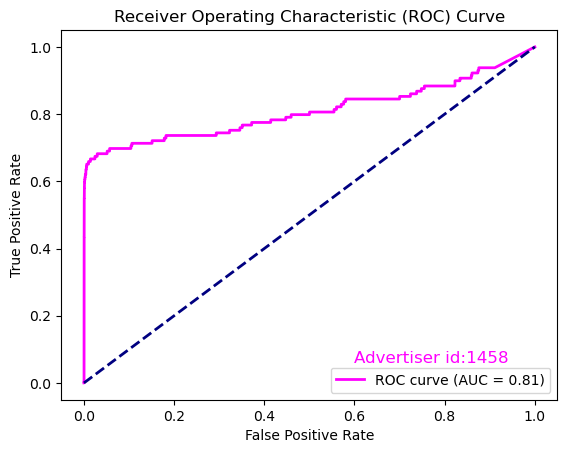

In [15]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='Magenta', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# plt.text(2, 22, "Advertiser id:3427", fontsize=12, color='red')
plt.text(tpr[-1] - 0.4, fpr[2500], "Advertiser id:1458", fontsize=12, color='Magenta')
plt.show()

In [16]:
import os

save_dir = "/Users/shreshthgarg/Desktop/hackathons/adobe_devcraft_final/model_weights_bin"
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

model.save_model(os.path.join(save_dir, "imp_clk_1458.bin"))


In [ ]:
import pickle
save_dir = "/Users/shreshthgarg/Desktop/hackathons/adobe_devcraft_final/model_weights_pk"
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)